In [1]:
import os

os.chdir("../")

In [2]:
import glob

mscx_path_list = []
for item in glob.glob("./xmls/mscx/*"):
    mscx_path_list.append(os.path.abspath(item))
mscx_path_list.sort()

tstree_path_list = []
for item in glob.glob("./xmls/tstree/*"):
    tstree_path_list.append(os.path.abspath(item))
tstree_path_list.sort()

In [3]:
from alm.lyrics import *
from alm.melody import *
from alm.comparator import *
from alm.utils import io
import pprint

In [4]:
def calc_word_matched_rate(mscx_path_list: list, tstree_path_list: list,):
    parser = grammar_parser.GrammarParser("ja_ginza")

    res = []

    if len(mscx_path_list) != len(tstree_path_list):
        return res

    for i in range(len(mscx_path_list)):
        mscx_path = mscx_path_list[i]
        ts_path = tstree_path_list[i]

        lyrics_notes_dict = lyrics_extractor.extract_lyrics(mscx_path)
        doc = parser.parse(lyrics_notes_dict[lyrics_extractor.LYRICS_KEY])
        lyrics_tree = parser.to_tree(doc)
        words_notes_dict = {}
        associating_lyrics_melody.explore_words_in_tree(lyrics_tree, words_notes_dict)
        words_list = associating_lyrics_melody.associate_word_list_notes(words_notes_dict, lyrics_notes_dict)

        melody_tree = time_span_tree.tstree_xml_2_struct(ts_path)

        rate = word_matched_rate_calculator.calc_word_matched_rate(words_list, melody_tree)
        rate.section_name = io.get_file_name(mscx_path)

        res.append(rate)
    
    return res

In [5]:
word_matched_rates = calc_word_matched_rate(mscx_path_list, tstree_path_list)

In [6]:
word_matched_rate_dict = {}
for item in word_matched_rates:
    song_name = item.section_name[:-2]
    section = item.section_name[-1]

    if song_name not in word_matched_rate_dict:
        word_matched_rate_dict[song_name] = [-1, -1, -1, -1]

    if section == "A":
        word_matched_rate_dict[song_name][0] = item.total_words_number
        word_matched_rate_dict[song_name][1] = item.matched_words_number
    elif section == "S":
        word_matched_rate_dict[song_name][2] = item.total_words_number
        word_matched_rate_dict[song_name][3] = item.matched_words_number

res = [] 
for key, value in word_matched_rate_dict.items():
    value.insert(0, key)
    res.append(value)

io.output_csv(
    "./csv/word_matched_rate.csv",
    ["楽曲名", "単語数_A", "一致した単語数_A", "単語数_S", "一致した単語数_S"],
    res
)

# 前処理

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [8]:
word_matched_rate = pd.read_csv("csv/word_matched_rate.csv")
popularities = pd.read_csv("csv/popularities.csv")
word_matched_rate = pd.merge(word_matched_rate, popularities)

center = len(word_matched_rate) // 2

word_matched_rate["一致率_A"] = word_matched_rate["一致した単語数_A"] / word_matched_rate["単語数_A"]
word_matched_rate["一致率_S"] = word_matched_rate["一致した単語数_S"] / word_matched_rate["単語数_S"]

spotify_popularity = word_matched_rate.sort_values("Spotify", ascending=False)
youtube_popularity = word_matched_rate.sort_values("Youtube", ascending=False)

# Youtubeにおける一致率の散布図

/tmp/ipykernel_68106/3106997234.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


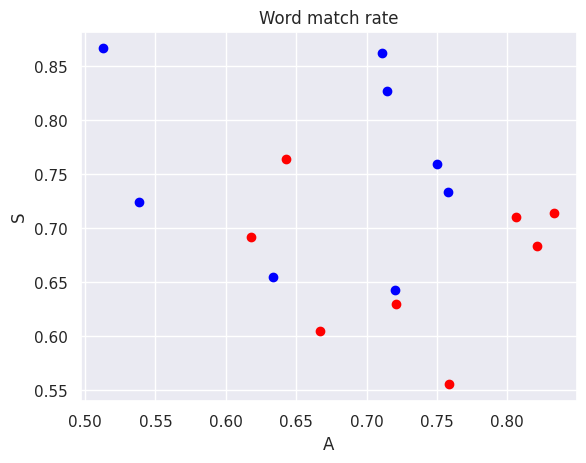

In [9]:
pop_youtube = youtube_popularity[:center]
unpop_youtube = youtube_popularity[center:]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(pop_youtube["一致率_A"], pop_youtube["一致率_S"], c='blue')
ax.scatter(unpop_youtube["一致率_A"], unpop_youtube["一致率_S"], c='red')
ax.set_title("Word match rate")
ax.set_xlabel('A')
ax.set_ylabel('S')
fig.show()

# Spotifyにおける一致率の散布図

/tmp/ipykernel_68106/707704620.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


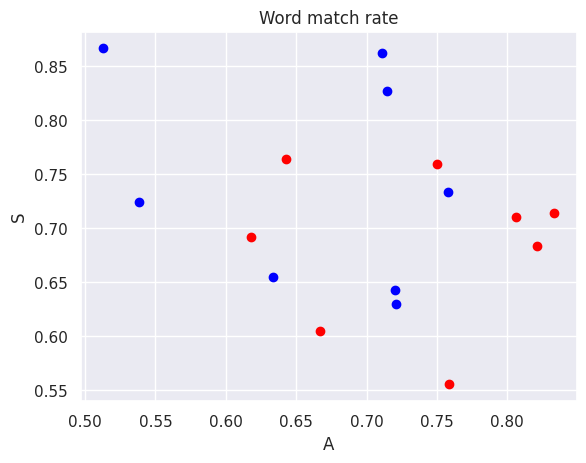

In [10]:
pop_spotify = spotify_popularity[:center]
unpop_spotify = spotify_popularity[center:]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(pop_spotify["一致率_A"], pop_spotify["一致率_S"], c='blue')
ax.scatter(unpop_spotify["一致率_A"], unpop_spotify["一致率_S"], c='red')
ax.set_title("Word match rate")
ax.set_xlabel('A')
ax.set_ylabel('S')
fig.show()

# Aメロとサビの一致率の差の計算

In [11]:
pop_youtube_distance = np.abs(pop_youtube["一致率_S"] - pop_youtube["一致率_A"]) / np.sqrt(2)
unpop_youtube_distance = np.abs(unpop_youtube["一致率_S"] - unpop_youtube["一致率_A"]) / np.sqrt(2)

pop_spotify_distance = np.abs(pop_spotify["一致率_S"] - pop_spotify["一致率_A"]) / np.sqrt(2)
unpop_spotify_distance = np.abs(unpop_spotify["一致率_S"] - unpop_spotify["一致率_A"]) / np.sqrt(2)

# Youtubeにおける一致率の差のヴァイオリンプロットと箱ひげ図

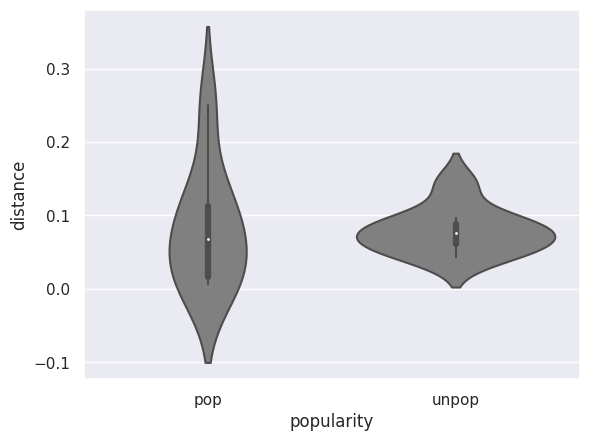

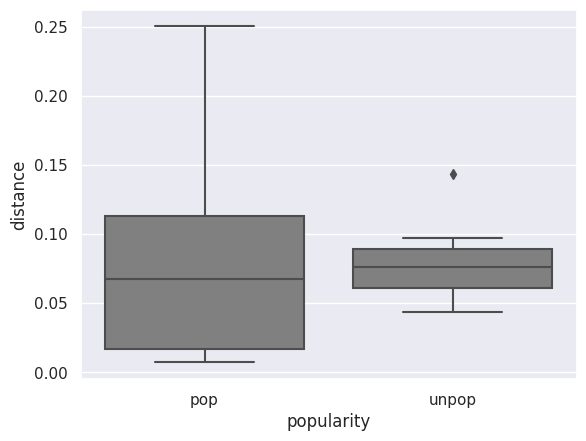

In [12]:
popularity = ["pop"] * len(pop_youtube_distance)
popularity.extend(["unpop"] * len(unpop_youtube_distance))

df_youtube_pop = pd.DataFrame({
    "popularity": ["pop"] * len(pop_youtube_distance),
    "distance": pop_youtube_distance,
})
df_youtube_unpop = pd.DataFrame({
    "popularity": ["unpop"] * len(unpop_youtube_distance),
    "distance": unpop_youtube_distance,
})
df_youtube = pd.concat([df_youtube_pop, df_youtube_unpop])

sns.violinplot(data=df_youtube, x="popularity", y="distance", color="gray")
plt.show()
sns.boxplot(data=df_youtube, x="popularity", y="distance", color='gray')
plt.show()

# Spotifyにおける一致率の差のヴァイオリンプロットと箱ひげ図

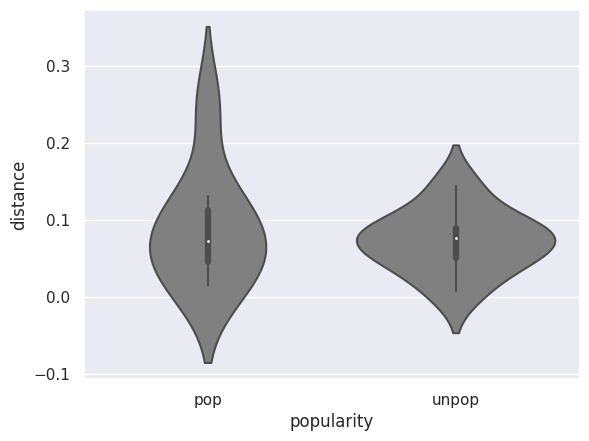

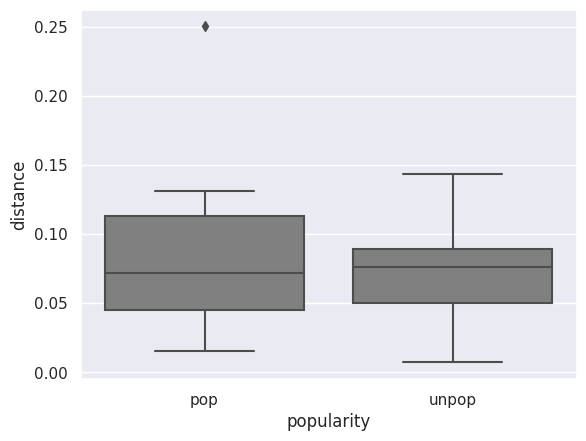

In [13]:
popularity = ["pop"] * len(pop_spotify_distance)
popularity.extend(["unpop"] * len(unpop_spotify_distance))

df_spotify_pop = pd.DataFrame({
    "popularity": ["pop"] * len(pop_spotify_distance),
    "distance": pop_spotify_distance,
})
df_spotify_unpop = pd.DataFrame({
    "popularity": ["unpop"] * len(unpop_spotify_distance),
    "distance": unpop_spotify_distance,
})
df_spotify = pd.concat([df_spotify_pop, df_spotify_unpop])

sns.violinplot(data=df_spotify, x="popularity", y="distance", color="gray")
plt.show()
sns.boxplot(data=df_spotify, x="popularity", y="distance", color='gray')
plt.show()

# t検定

In [14]:
# print(stats.ttest_ind(pop_youtube_distance, unpop_youtube_distance, equal_var=False, alternative='two-sided'))

In [15]:
# print(stats.ttest_ind(pop_spotify_distance, unpop_spotify_distance, equal_var=False, alternative='two-sided'))